# M3 data processing

This jupyter notebook is for processing M3 data.

**Summary :**

1. [Install gdal and other packages](#1) <br>
2. [Define folder paths and file names](#2) <br>
    2.1 [Folder paths](#2.1) <br>
    2.2 [File names](#2.2) <br>
3. [Read the dataset information](#3) <br>
    3.1 [Methods and functions to gather information from the dataset](#3.1) <br>
4. [Crop the dataset (if needed)](#4) <br>
    4.1. [Check if we need to crop the dataset](#4.1) <br>
    4.2. [Crop the dataset](#4.2) <br>
    4.3. [Save the new dataset as an array](#4.3) <br>
5. [Write and save a reflectance matrix](#5) <br>
    5.1. [Useful functions to access the pixel informations of the new dataset](#5.1) <br>
    5.2. [Write and save a 1578,86nm reflectance matrix](#5.2) <br>
    5.3. [Create a reflectance matrix at 1578.86 nm](#5.3) <br>
    5.4. [Read the file obtained](#5.4) <br>
6. [Derive the band depth](#6) <br>
7. [Derive the integrated band depth (IBD)](#7) <br>
8. [Write and save IBD1000 and IBD2000 matrix](#8) <br>
    8.1. [Define IBD1000 and IBD2000](#8.1) <br>
    8.2. [Create an IBD1000 matrix](#8.2) <br>
    8.3. [Read the IBD1000 matrix](#8.3) <br>
    8.4. [Create an IBD2000 matrix](#8.4) <br>
    8.5. [Read the IBD2000 matrix](#8.5) <br>
9. [Generate the rasters](#9) <br>
    9.1. [Functions we will use](#9.1) <br>
    9.2. [Generate the reflectance 1580nm raster](#9.2) <br>
    9.3. [Generate the IBD1000 raster](#9.3) <br>
    9.4. [Generate the IBD2000 raster](#9.4) <br>
    9.5. [Print the image obtained](#9.5) <br>



<a id="1"></a>
## 1. Install gdal and other packages


The language used in the script is Python 3.9.16

Steps from section 1 are for installing the packages needed to run the code.

Here, we use 'pip' to install the packages (it is available in my virtual environment), but you might use 'conda' or 'brew' depending on your own environment.

In [7]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install gdal

Note: you may need to restart the kernel to use updated packages.


In [10]:
## Import numpy and matplotlib :
import numpy as np
import matplotlib.pyplot as plt

## Imports python GDAL and exits the program if the modules are not found :
import sys, os 

try:
    from osgeo import gdal, osr, ogr
    print(gdal,'\n', osr, '\n', ogr) # gdal, osr and ogr are in the osgeo directory
except:
    sys.exit('ERROR: cannot find GDAL/OGR modules')

<module 'osgeo.gdal' from '/opt/anaconda3/envs/m3-repo/lib/python3.9/site-packages/osgeo/gdal.py'> 
 <module 'osgeo.osr' from '/opt/anaconda3/envs/m3-repo/lib/python3.9/site-packages/osgeo/osr.py'> 
 <module 'osgeo.ogr' from '/opt/anaconda3/envs/m3-repo/lib/python3.9/site-packages/osgeo/ogr.py'>


In [11]:
## Check which Version of GDAL/OGR is installed :

version_num = int(gdal.VersionInfo('VERSION_NUM'))
print(version_num)
if version_num < 1100000:
    sys.exit('ERROR: Python bindings of GDAL 1.10 or later required')

3060000


In [12]:
## Install the drivers :

# Charge drivers to use them.
# For charging all drivers at once (for reading a raster, not writing), use :
gdal.AllRegister()

# Create a driver
driver = gdal.GetDriverByName('HFA') 
# This driver is built-in by default GDAL supports Erdas Imagine .img format for read access and write.

# Save it :
driver.Register()

7

<a id="2"></a>
## 2. Define folder paths and file names :

<a id="2.1"></a>
### 2.1. Folder paths :
You'll need to change the rootpath when working on your own computer.

In [13]:
## The root path of your folder (where you downloaded the jupyter notebook):
rootpath = "/Users/ines.torres/Desktop/Apollo_Basin/jupyter_notebook/"

## Different folders we'll use :
RFLfolderpath = rootpath+"RFL_data"
LOCfolderpath = rootpath+"LOC_data"
Matrixfolderpath = rootpath+"generated_matrix"
Rasterfolderpath = rootpath+"generated_rasters"

In [14]:
print('Content of the reflectance folder (RLF_data) :\n')
!ls '/Users/ines.torres/Desktop/Apollo_Basin/jupyter_notebook/RFL_data'

print('\nContent of the location folder (LOC_files) :\n')
!ls "/Users/ines.torres/Desktop/Apollo_Basin/jupyter_notebook/LOC_data"

Content of the reflectance folder (RLF_data) :

ls: /Users/ines.torres/Desktop/Apollo_Basin/jupyter_notebook/RFL_data: No such file or directory

Content of the location folder (LOC_files) :

ls: /Users/ines.torres/Desktop/Apollo_Basin/jupyter_notebook/LOC_data: No such file or directory


<a id="2.2"></a>
### 2.2. File names :

Define the name of the file we want to create a raster with.

M3 products have the following file names:

Info available on the website :
https://ode.rsl.wustl.edu/mars/pagehelp/Content/Missions_Instruments/ISRO_Chandrayaan-1/M3/CALIMG.htm

In [15]:
print('Which file do you want to convert into a raster ?\n')

file = input('Your answer - with the M3xyyyymmddThhmmss format: ')

Which file do you want to convert into a raster ?



Finding the corresponding file in the reflectance and location folders :

In [16]:
# Reflectance data :
RFLDATAfile_name = file+'_V01_RFL.IMG' #"M3G20090718T054612_V01_RFL.IMG"

# (Moon) location of the reflectance data
LOCfile_name = file+'_V01_LOC.IMG'  #"M3G20090718T054612_V01_LOC.IMG"  

Name of the reflectance and IBD matrix we will create :

In [17]:
# Reflectance matrix we'll create :
#RFLfile_name = "no_offset_rfl1580_M3G20090718T054612.txt"
RFLfile_name = file+'_RFL1580.txt'  #"M3G20090718T054612_V01_RFL1580.txt"

# IBD matrix we'll create, the first for IBD1000...
IBD1000file_name = file+'_IBD1000.txt'  #"M3G20090718T054612_V01_IBD1000.txt" 

# ... or the second for IBD2000
IBD2000file_name = file+'_IBD2000.txt' #"M3G20090718T054612_V01_IBD2000.txt"

Check if the file we chose exists in the reflectance and location folders :

In [18]:
# Read the selected raster as a dataset :
filepath = os.path.join(RFLfolderpath,RFLDATAfile_name)
print('Raster reflectance path :', filepath, '\n')

LOCfilepath = os.path.join(RFLfolderpath,LOCfile_name)
print('Raster location path :', LOCfilepath, '\n')

# open the data set in read only mode :
DATASET = gdal.Open(filepath, gdal.GA_ReadOnly)
print('Raster data type :', type(DATASET))

# The .Open() method takes 2 parameters : the path of the file and the lecture mode. 
# 2 possible constants for the lecture mode :
GA_ReadOnly = 0
GA_Update = 1
# If python sends an error essage for GA_ReadOnly, you can just type its value (0)

# After DATASET is charged, test if we can open the data.
if DATASET is None:
    print('Imposible to open',file)
    sys.exit(1)

# DATASET is a global variable :
global DATASET

Raster reflectance path : /Users/ines.torres/Desktop/Apollo_Basin/jupyter_notebook/RFL_data/_V01_RFL.IMG 

Raster location path : /Users/ines.torres/Desktop/Apollo_Basin/jupyter_notebook/RFL_data/_V01_LOC.IMG 

Raster data type : <class 'NoneType'>
Imposible to open 


ERROR 4: /Users/ines.torres/Desktop/Apollo_Basin/jupyter_notebook/RFL_data/_V01_RFL.IMG: No such file or directory


SystemExit: 1

/opt/anaconda3/envs/m3-repo/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<a id="3"></a>
## 3. Read the dataset information :

Now that we selected the data we want to process, let's read its information.

The raster has the following structure :
* RasterYSize Lines
* 304 (RasterXSize) Samples
* 85 Channels or Bands

See the picture below, from the Orbital Data Explorer User's Manual : https://ode.rsl.wustl.edu/moon/pagehelp/quickstartguide/index.html?m3_refimg.htm

![title](notebook_img/M3_operation_modes.png)

<a id="3.1"></a>
### 3.1. Methods and functions to gather information from the dataset

* Methods : RasterYSize, RasterXSize, RasterCount, GetMetadata
* Functions : get_bands, get_wavelengths, band2wvl, wvl2band, goodmodulo

In [ ]:
## Some methods to gather information from our dataset :

# Get the X Size, the Y Size and the number of bands of the dataset :
print('XSize (Samples):',DATASET.RasterXSize)
print('YSize (Lines):',DATASET.RasterYSize)
print('Channels (Bands):',DATASET.RasterCount)

# Get the Bands of the dataset :
BANDS = DATASET.GetMetadata()
print('\nMetadata type :',type(BANDS))
print('Metadata are :', BANDS)

XSize (Samples): 304
YSize (Lines): 30642
Channels (Bands): 85

Metadata type : <class 'dict'>
Metadata are : {'Band_1': '460.9900', 'Band_10': '770.4000', 'Band_11': '790.3700', 'Band_12': '810.3300', 'Band_13': '830.2900', 'Band_14': '850.2500', 'Band_15': '870.2100', 'Band_16': '890.1700', 'Band_17': '910.1400', 'Band_18': '930.1000', 'Band_19': '950.0600', 'Band_2': '500.9200', 'Band_20': '970.0200', 'Band_21': '989.9800', 'Band_22': '1009.950', 'Band_23': '1029.910', 'Band_24': '1049.870', 'Band_25': '1069.830', 'Band_26': '1089.790', 'Band_27': '1109.760', 'Band_28': '1129.720', 'Band_29': '1149.680', 'Band_3': '540.8400', 'Band_30': '1169.640', 'Band_31': '1189.600', 'Band_32': '1209.570', 'Band_33': '1229.530', 'Band_34': '1249.490', 'Band_35': '1269.450', 'Band_36': '1289.410', 'Band_37': '1309.380', 'Band_38': '1329.340', 'Band_39': '1349.300', 'Band_4': '580.7600', 'Band_40': '1369.260', 'Band_41': '1389.220', 'Band_42': '1409.190', 'Band_43': '1429.150', 'Band_44': '1449.11

In [ ]:
## Change the bands from a dictionary type to an array type in order to 
## have the wavelenghts and the bands sorted in a good order :

# Entry variable : the dataset we want to sort
# Return : list of bands sorted in right order 
def get_bands(dataset):
  dictionary = dataset.GetMetadata()

  ## Get the Keys (bands) :
  listOfKeys = dictionary.keys()
  bands = list(listOfKeys)

  ## Sort the bands in the right order :
  # From Band 2 to Band 8 :
  for index in range (1,8) :
    bands.insert(index,bands[index*10 + index])
    bands.pop(index*10 + index + 1)  
  # For the 9th Band (in position 85), it's not the same :
  bands.insert(8,bands[-1])
  bands.pop()

  ## Change 'Band_n' into n with n as an integer :
  bands = [ string.replace("Band_","") for string in bands ]
  bands = [ int(string) for string in bands ]

  return bands


# Entry variable : the dataset we want to sort
# Return : list of wavelengths sorted in right order
def get_wavelengths(dataset):
  dictionary = dataset.GetMetadata()

  ## Get the Values (wavelengths) :
  listOfValues = dictionary.values()
  listOfValues = list(listOfValues)
  wavelengths = [float(value) for value in listOfValues] # change the strings to floats

  ## Sort the wavelengths in the right order :
  # From Band 2 to Band 8 :
  for index in range (1,8) :
    wavelengths.insert(index,wavelengths[index*10 + index])
    wavelengths.pop(index*10 + index + 1)
  # For the 9th Band (in position 85), it's not the same :
  wavelengths.insert(8,wavelengths[-1])
  wavelengths.pop()

  return wavelengths

# Set the variable BANDS as the list of bands
BANDS = get_bands(DATASET)
# Set the variable WV as the list of wavelengths
WV = get_wavelengths(DATASET)

# Set these variables as globals
global BANDS, WV

print("Bands :", BANDS)
print("Wavelengths :", WV)

Bands : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]
Wavelengths : [460.99, 500.92, 540.84, 580.76, 620.69, 660.61, 700.54, 730.48, 750.44, 770.4, 790.37, 810.33, 830.29, 850.25, 870.21, 890.17, 910.14, 930.1, 950.06, 970.02, 989.98, 1009.95, 1029.91, 1049.87, 1069.83, 1089.79, 1109.76, 1129.72, 1149.68, 1169.64, 1189.6, 1209.57, 1229.53, 1249.49, 1269.45, 1289.41, 1309.38, 1329.34, 1349.3, 1369.26, 1389.22, 1409.19, 1429.15, 1449.11, 1469.07, 1489.03, 1508.99, 1528.96, 1548.92, 1578.86, 1618.79, 1658.71, 1698.63, 1738.56, 1778.48, 1818.4, 1858.33, 1898.25, 1938.18, 1978.1, 2018.02, 2057.95, 2097.87, 2137.8, 2177.72, 2217.64, 2257.57, 2297.49, 2337.42, 2377.34, 2417.26, 2457.19, 2497.11, 2537.03, 2576.96

In [ ]:
## Function that returns the wavelength when given the number of the band.
# Entry variable : number of the band (from 1 to 85)
# Return : wavelength value (nm)
def band2wvl(band_number) :
    return WV[band_number - 1]

## Function that returns the band when given the wavelength.
# Entry variable : wavelength value (nm)
# Return : number of the band (from 1 to 85)
def wvl2band(wvl) :
  i = WV.index(wvl)
  return BANDS[i]

# Example :
print('What is the wavelength of the 3rd band ?   ', band2wvl(3), 'nm')
print('What is the 540.84 nm band ?   ', wvl2band(540.84))

What is the wavelength of the 3rd band ?    540.84 nm
What is the 540.84 nm band ?    3


In [ ]:
import math

## Function that gives the angle in degrees with the good modulo :
## longitude between -180° and +180°
## latitude between -90° and 90°
def goodmodulo(long, lat) :

  # longitude should be between -180° and 180° :
  if long > 180 :
    long = -180 + (long%180)
  if long < -180 :
    long = 180 + (long%-180)

  # latitude should be between -90° and 90° :
  if lat > 90 :
    lat = -90 + (lat%90)
  if lat < -90 :
    lat = 90 + (lat%-90)

  return long,lat

<a id="4"></a>
## 4. Crop the dataset - if needed

<a id="4.1"></a>
### 4.1. Check if we need to crop the dataset :
We use the _LOC file that indicates the longitude, latitude, radius for each pixel. It is located in the radiance version 01 file from the Lunar Orbiter Data website.

In [ ]:
# open the file in read only mode :
LOCfilepath = os.path.join(LOCfolderpath,LOCfile_name)
LOC = gdal.Open(LOCfilepath, gdal.GA_ReadOnly)

lines = LOC.RasterYSize
rows = LOC.RasterXSize

# write the location data as a list of matrix 'M3_LOC' :
M3_LOC = [np.zeros((lines,rows)) for i in range (3)]
for i in range(1,4) :
    band = LOC.GetRasterBand(i)
    M3_LOC[i-1] = band.ReadAsArray()

# Longitude is band 1, Latitude band 2 and radius band 3 :
LONG_init = M3_LOC[0]
LAT_init = M3_LOC[1]
RAD_init = M3_LOC[2]

print("Shape of the original longitude, latitude and radius matrix :", LONG_init.shape, '\n')

min_long,min_lat = goodmodulo(LONG_init[-1][0],LAT_init[-1][0])
max_long,max_lat = goodmodulo(LONG_init[0][-1],LAT_init[0][-1])

print("Minimum latitude :", min_lat, 'degrees')
print("Maximum latitude :", max_lat, "degrees\n")
print("Easternmost longitude :", min_long,'degrees')
print("Westernmost longitude :", max_long,'degrees')
# these values might seem strange because the imager goes from North Pole to South Pole
# in the poles, longitude values vary widely.

Shape of the original longitude, latitude and radius matrix : (30642, 304) 

Minimum latitude : -87.58094143582018 degrees
Maximum latitude : 55.6366955539239 degrees

Easternmost longitude : 20.898446996890904 degrees
Westernmost longitude : -160.32889258991347 degrees


Most data downloaded from the Lunar orbital data explorer website was taken from North Pole to South Pole (the satellite has a polar orbit).
We need to crop the dataset in order to keep ONLY the data inside the Apollo Basin. Here are the values of Apollo mininum and maximum latitude, as well as easternmost and westernmost longitude :

![title](notebook_img/Apollo_basin_long_lat.png)

<a id="4.2"></a>
### 4.2. Crop the dataset :

If the values obtained above shows that your data is not only the Apollo Basin, you need to run this section to crop the dataset.

In [ ]:
## Function that selects the right zone : Apollo Basin

# Entry variable : the latitude matrix of the dataset we want to cut.
# Return : tuple with the minimum and maximum pixel line of the right zone.
def goodlocation(lat_matrix, N_lat, S_lat):
    i = 0
    while lat_matrix[i][0] > N_lat :
        i+=1
    min_line = i
    while lat_matrix[i][0] > S_lat :
        i+=1
    max_line = i
    return min_line, max_line


# Cut the location file such as:
N_most_lat = -28.1    #in degrees
S_most_lat = -44.1    #in degrees
(min_line , max_line) = goodlocation(LAT_init, N_most_lat, S_most_lat)
print("Minimum and maximum line of the original raster : ", (min_line , max_line), '\n')

# New longitude, latitude and radius matrix :
LONG = LONG_init[min_line:max_line]
LAT = LAT_init[min_line:max_line]
RAD = RAD_init[min_line:max_line]

# New number of lines and rows :
(lines, rows) = LONG.shape

print('Shape of the new longitude, latitude and radius matrix :', LONG.shape, '\n')

min_long,min_lat = goodmodulo(LONG[-1][0],LAT[-1][0])
max_long,max_lat = goodmodulo(LONG[0][-1],LAT[0][-1])

print("Minimum latitude :", min_lat, 'degrees')
print("Maximum latitude :", max_lat, "degrees\n")
print("Easternmost longitude :", min_long,'degrees')
print("Westernmost longitude :", max_long,'degrees')

Minimum and maximum line of the original raster :  (17401, 20691) 

Shape of the new longitude, latitude and radius matrix : (3290, 304) 

Minimum latitude : -44.099489016085506 degrees
Maximum latitude : -28.146041783065574 degrees

Easternmost longitude : -161.55197855827376 degrees
Westernmost longitude : -158.84261231957066 degrees


<a id="4.3"></a>
### 4.3. Save the new dataset as an array :

In [ ]:
## Work on a shorter dataset :

# let's shorten the dataset Y size, and just take the values between min_line and max_line 
# then, YSize/lines = 760 and XSize/columns = 305 : 
M3_IMAGE = [np.zeros((lines,rows)) for i in range (85)]

# the n-th element of the list bands is the reflectance matrix of the n-th band :
for i in range(1,86) :
  band = DATASET.GetRasterBand(i)
  M3_IMAGE[i-1] = band.ReadAsArray()[min_line : max_line]

global M3_IMAGE

In [ ]:
# Gather some information on the dataset
print("How many bands has one M3 image ?", len(M3_IMAGE))
print("Shape of one reflectance matrix :", M3_IMAGE[0].shape)
print("\nFor example, the 3rd band has the following reflectance matrix :\n", M3_IMAGE[2])

How many bands has one M3 image ? 85
Shape of one reflectance matrix : (3290, 304)

For example, the 3rd band has the following reflectance matrix :
 [[0.07294366 0.06754027 0.06492262 ... 0.05801738 0.05753946 0.05917937]
 [0.07139561 0.0652006  0.06402391 ... 0.06042344 0.0593045  0.06045548]
 [0.07231093 0.06695328 0.06355301 ... 0.06042605 0.06225126 0.06168271]
 ...
 [0.03818596 0.03411992 0.03409585 ... 0.03570092 0.03688142 0.03678827]
 [0.03805674 0.03401018 0.03472942 ... 0.03466609 0.03651509 0.03566183]
 [0.03962372 0.037066   0.03615788 ... 0.03516749 0.03619048 0.03533891]]


<a id="5"></a>
## 5. Write and save a reflectance matrix

<a id="5.1"></a>
### 5.1 Useful functions to access the pixel informations of the new dataset

You'll find :
* Functions : raster2array, band2rfl, wvl2rfl
* Plot of the reflectance spectrum for one pixel.

In [ ]:
## Read the raster as an array :

# Entry variables : raster dataset, band number.
# Return : the band as an array.
def raster2array(dataset, band_number):
  return dataset[band_number - 1]


# This raster is an array of size : 11738 (X Size, Lines) x 304 (Y Size, Samples)
# When reading a raster as an array (a matrix), lines are X and columns (or samples) are Y.
print('Number of lines (X) :',len(raster2array(M3_IMAGE,3)))
print('Number of samples (Y) :',len(raster2array(M3_IMAGE,3)[0]))

Number of lines (X) : 3290
Number of samples (Y) : 304


In [ ]:
## Get the reflectance of one pixel depending on the band number, or the wavelength :

# Position of the pixel we are working with :
X = 250   # lines from 0 to 337
Y = 250   # samples 0 to 303 


# Entry variables : band_number;  (x,y) position of the pixel
# Return : the reflectance in % of the pixel of the band_number 
def band2rfl(band_number, x, y) :
  return raster2array(M3_IMAGE,band_number)[x][y]


# Entry variables : position of the pixel (X and Y), wavelength wv
# Return : the reflectance in % of the (X,Y) pixel at wv
def wvl2rfl(wv, x, y) :
  band_number = WV.index(wv) + 1
  return raster2array(M3_IMAGE,band_number)[x][y]

# Each value is the reflectance of a pixel in % :
# For example, the reflectance of the pixel in position (400,50) is :
print("Reflectance of the pixel", (X,Y) ,"of the 3rd band :", band2rfl(3, X, Y), '%')
print("Reflectance of the pixel", (X,Y), "at 540.84 nm :", wvl2rfl(540.84, X, Y), '%')

Reflectance of the pixel (250, 250) of the 3rd band : 0.062349465 %
Reflectance of the pixel (250, 250) at 540.84 nm : 0.062349465 %


Now that we can obtain the relectance of each pixel, let's produce the spectrums of each pixel :

In [ ]:
## Create a function that returns a list of reflectances for one pixel in the X,Y position :

# Entry : x,y position of the pixel (X : from 0 to 11737) (Y : from 0 to 303) 
# Return : 3 lists : - bands for which reflectence is not -999.0
#                    - wavelengths for which reflectance is not -999.0
#                    - reflectances for each band (when reflectance is not -999.0)              
def rfl_spectrum(x, y) :
  band = []
  wv = []
  rfl = []
  for n in BANDS :
    reflectance = band2rfl(n, x, y)
    # If rfl is different from -999, add it to the list :
    if reflectance != -999.0 :
      band.append(n)
      wv.append(WV[n-1])
      rfl.append(reflectance)
  return band , wv , rfl

# Set the variables BANDS, WV, RFL as the new bands wavelengths and reflectances without errors.
BANDS_no_error, WV_no_error, RFL_no_error = rfl_spectrum(X,Y)[0], rfl_spectrum(X,Y)[1], rfl_spectrum(X,Y)[2]

global BANDS_no_error, WV_no_error, RFL_no_error

# For example : list of radiances of the (0,0) pixel for all the bands.
print('Bands without errors :\n',BANDS_no_error,'\n' ,'Length :',len(BANDS_no_error))
print('\nWavelengths without errors :\n',WV_no_error,'\n','Length :' ,len(WV_no_error))
print('\nReflectances of the (0,0) pixel for all the bands :\n',RFL_no_error,'\n','Length :', len(RFL_no_error))

Bands without errors :
 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85] 
 Length : 83

Wavelengths without errors :
 [540.84, 580.76, 620.69, 660.61, 700.54, 730.48, 750.44, 770.4, 790.37, 810.33, 830.29, 850.25, 870.21, 890.17, 910.14, 930.1, 950.06, 970.02, 989.98, 1009.95, 1029.91, 1049.87, 1069.83, 1089.79, 1109.76, 1129.72, 1149.68, 1169.64, 1189.6, 1209.57, 1229.53, 1249.49, 1269.45, 1289.41, 1309.38, 1329.34, 1349.3, 1369.26, 1389.22, 1409.19, 1429.15, 1449.11, 1469.07, 1489.03, 1508.99, 1528.96, 1548.92, 1578.86, 1618.79, 1658.71, 1698.63, 1738.56, 1778.48, 1818.4, 1858.33, 1898.25, 1938.18, 1978.1, 2018.02, 2057.95, 2097.87, 2137.8, 2177.72, 2217.64, 2257.57, 2297.49, 2337.42, 2377.34, 2417.26, 2457.19, 

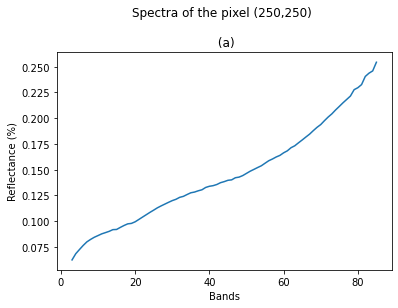

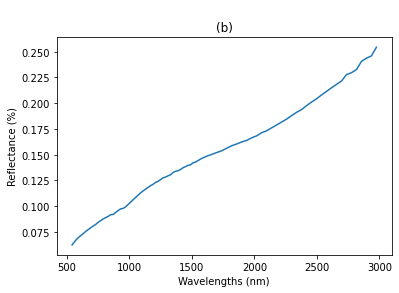

In [ ]:
## Plot the graph (Bands, Reflectances):
plt.plot(BANDS_no_error, RFL_no_error)
plt.xlabel('Bands')
plt.ylabel('Reflectance (%)')
plt.title('Spectra of the pixel ({},{}) \n\n (a)'.format(X,Y))
plt.show()

## Plot the graph (Wavelengths, Reflectances):
plt.plot(WV_no_error , RFL_no_error)
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Reflectance (%)')
plt.title('\n(b)')
plt.show()

<a id="5.2"></a>
### 5.2. Write and save a 1578,86nm reflectance matrix :

Example of a reflectance matrix :

In [ ]:
# For example :
print('Reflectance matrix of the 50th band :\n', M3_IMAGE[49] ,'\n\nShape :', M3_IMAGE[49].shape)

Reflectance matrix of the 50th band :
 [[0.16662729 0.1585196  0.1559744  ... 0.13517365 0.13563527 0.13972704]
 [0.1636377  0.1553238  0.15331706 ... 0.13847885 0.13837484 0.14057837]
 [0.16363361 0.15713747 0.15198661 ... 0.13893017 0.14200945 0.14185262]
 ...
 [0.09804436 0.09318689 0.09436197 ... 0.09652922 0.09686357 0.09739467]
 [0.09974795 0.09565569 0.09677351 ... 0.09512292 0.09482779 0.09584713]
 [0.10559211 0.10132907 0.09936319 ... 0.09507068 0.09448478 0.09436557]] 

Shape : (3290, 304)


<a id="5.3"></a>
### 5.3. Create a reflectance matrix at 1578.86 nm :

In [ ]:
## Create a reflectance matrix at 1578.86 nm :
index = WV.index(1578.86)
matrix = M3_IMAGE[index]

## Save the reflectance matrix :
print('Matrix shape :', matrix.shape,'\n\nValues :\n' , matrix)
Matrixfilepath = os.path.join(Matrixfolderpath,RFLfile_name)
np.savetxt(Matrixfilepath, matrix)

Matrix shape : (3290, 304) 

Values :
 [[0.16662729 0.1585196  0.1559744  ... 0.13517365 0.13563527 0.13972704]
 [0.1636377  0.1553238  0.15331706 ... 0.13847885 0.13837484 0.14057837]
 [0.16363361 0.15713747 0.15198661 ... 0.13893017 0.14200945 0.14185262]
 ...
 [0.09804436 0.09318689 0.09436197 ... 0.09652922 0.09686357 0.09739467]
 [0.09974795 0.09565569 0.09677351 ... 0.09512292 0.09482779 0.09584713]
 [0.10559211 0.10132907 0.09936319 ... 0.09507068 0.09448478 0.09436557]]


<a id="5.4"></a>
### 5.4. Read the file obtained :

In [ ]:
## Read the file, to check and have the good values (*1000) :
Matrixfilepath_RFL = os.path.join(Matrixfolderpath,RFLfile_name)

# we multiply the values by 1000 because the image takes values between 255 and 0 :
matrix_RFL = 1000*np.loadtxt(Matrixfilepath_RFL)

# Caracteristics of the matrix :
print('Matrix shape :', matrix_RFL.shape,'\n')
print("Minimum :", matrix_RFL.min()) 
print("Maximum :", matrix_RFL.max())
print("Mean :", matrix_RFL.mean(),'\n')
print("Values :\n" , matrix_RFL)

Matrix shape : (3290, 304) 

Minimum : 49.59186539053917
Maximum : 260.9294354915619
Mean : 117.97572038416669 

Values :
 [[166.62728786 158.51959586 155.97440302 ... 135.1736486  135.63527167
  139.72704113]
 [163.6376977  155.32380342 153.31706405 ... 138.47884536 138.37483525
  140.57837427]
 [163.63361478 157.13746846 151.98661387 ... 138.93017173 142.00945199
  141.85261726]
 ...
 [ 98.04435819  93.18689257  94.36196834 ...  96.52922302  96.86356783
   97.39466757]
 [ 99.74794835  95.65568715  96.77350521 ...  95.12291849  94.82779354
   95.84712982]
 [105.59210926 101.32906586  99.36319292 ...  95.07067502  94.48478371
   94.36556697]]


<a id="6"></a>
## 6. Derive the Band Depth (BD)


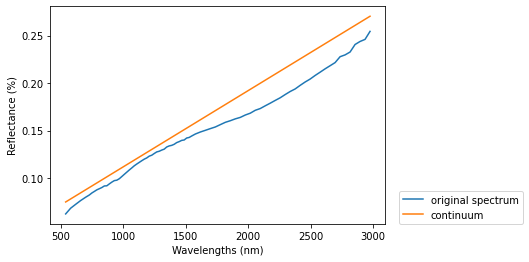

In [ ]:
## Plot a continuum spectrum :

X,Y = 100,100

# Tie points at 730.48nm and 1618.79nm
TP1 = 730.48
TP2 = 1618.79

# 1st try : the continuum is a straight line between TP1 = 730.48nm and TP2 = 1618.79nm :
# Entry variable : WV  wavelength ; x,y position of the pixel
# Return : the continuum function (affine function) value at WV
def continuum_1(WV, x, y):
  # Find the correct reflectance at TP1 and TP2 :
  rfl_TP1 = wvl2rfl(TP1, x, y)
  rfl_TP2 = wvl2rfl(TP2, x, y)
  return (rfl_TP2 - rfl_TP1)/(TP2-TP1)*(WV - TP1) + rfl_TP1 #+ 0.005

# Plot the continuum and the reflectance :
Continuum = [continuum_1(wv, X, Y) for wv in WV_no_error]
plt.plot(WV_no_error , RFL_no_error)
plt.plot(WV_no_error , Continuum)
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Reflectance (%)')
plt.legend(["original spectrum", "continuum"],loc=(1.04,0))
plt.show()

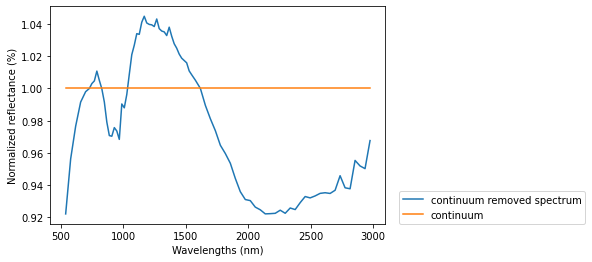

In [ ]:
## Plot a normalized spectrum :

def norm_rfl(wv, x, y) :
  return wvl2rfl(wv, x, y)/continuum_1(wv, x, y)


Normalized_Rfl = [norm_rfl(wv, X, Y) for wv in WV_no_error]
Continuum = [1 for wv in WV_no_error]
plt.plot(WV_no_error , Normalized_Rfl)
plt.plot(WV_no_error , Continuum)
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Normalized reflectance (%)')
plt.legend(["continuum removed spectrum", "continuum"],loc=(1.04,0))
plt.show()

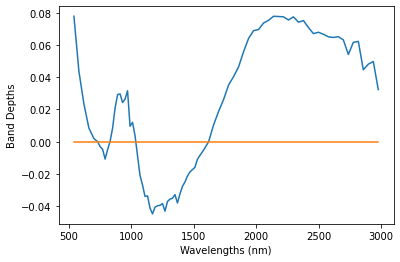

In [ ]:
## Calculate the Band Depth at a given wavelength:

# Entry variable : wavelength wv, x, y position of the pixel.
# Return : band depth with respect to the continuum
def band_depth (wv, x, y) :
  return 1 - norm_rfl(wv, x, y)

# Plot the Band Depth at each wavelength
BD = [band_depth (wv, X, Y) for wv in WV_no_error ]
zeros = [0 for wv in WV_no_error ]
plt.plot(WV_no_error , BD)
plt.plot(WV_no_error, zeros)
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Band Depths')
plt.show()

<a id="7"></a>
## 7. Derive the Integrated Band Depth (IBD)

In [ ]:
## Calculate the Integrated Band Depth of a wavelength interval :

# Entry variable : wv_min and wv_max, max and min of the wavelength interval, x, y position of the pixel.
# Return : integrated band depth
def IBD(wv_min, wv_max, x, y) :
  IBD = 0
  i_min = WV_no_error.index(wv_min)
  i_max = WV_no_error.index(wv_max)
  for i in range (i_min, i_max + 1) :
    IBD += band_depth(WV_no_error[i], x , y)
  return IBD

<a id="8"></a>
## 8. Write and save IBD1000 and IBD2000 matrix

<a id="8.1"></a>
### 8.1. Define IBD1000 and IBD2000 :

In [ ]:
## IBD 1micron and IBD 2micron are the most interesting IBD.
## We want to create an RGB with IBD1000 and IBD2000

IBD1000_WV_min = 790.37
IBD1000_WV_max = 1309.38
print("Pixel",(X,Y))
print('IBD1000 between 790.37 and 1309.38nm :', IBD(IBD1000_WV_min,IBD1000_WV_max, X, Y) )

IBD2000_WV_min = 1658.71
IBD2000_WV_max = 2497.11
print('IBD2000 between 1658.71 and 2497.11nm :', IBD(IBD2000_WV_min,IBD2000_WV_max, X, Y) )

Pixel (100, 100)
IBD1000 between 790.37 and 1309.38nm : -0.30392074019737325
IBD2000 between 1658.71 and 2497.11nm : 1.3265488705302244


In [ ]:
## Function that creates an array with IBD calculated for each pixel :

# Entry : minimum and maximum wavelengths of IBD
# Return : IBD array
def IBD_array(wv_min,wv_max):
  array = np.zeros((lines, rows))
  for X in range(lines):   # X goes from 0 to 759
    for Y in range(rows):  # Y goes from 0 to 303 
      array[X][Y] = IBD(wv_min, wv_max, X, Y)
      #print(X ,Y, array[X][Y])
  return array

<a id="8.2"></a>
### 8.2. Create an IBD1000 matrix :
This section takes ~10min to run - if you haven't created a matrix before. Otherwise, run the next section (8.3).

In [ ]:
## Create and Save the IBD file :
matrix_1000 = IBD_array(IBD1000_WV_min, IBD1000_WV_max)
print('Matrix shape :', matrix_1000.shape,'\n\nValues :\n' , matrix_1000)
Matrixfilepath = os.path.join(Matrixfolderpath,IBD1000file_name)
np.savetxt(Matrixfilepath, matrix_1000)

Matrix shape : (3290, 304) 

Values :
 [[-0.32291846  0.20792272 -0.45644975 ... -0.46386382 -0.35108842
  -0.39853532]
 [-0.43097806  0.21402772 -0.48191977 ... -0.43976493 -0.33301011
  -0.46792364]
 [-0.41626897 -0.23434068 -0.49478706 ... -0.42407879 -0.37266828
  -0.53751242]
 ...
 [-0.23563291 -0.15900993  0.18649241 ...  0.19765518  0.41278489
   0.66981661]
 [ 0.06990653 -0.06017663  0.05865205 ...  0.02644961  0.42277052
   0.67116367]
 [ 0.06029457 -0.04339003  0.21916622 ...  0.17519427  0.57666524
   0.71480481]]


<a id="8.3"></a>
### 8.3. Read the IBD1000 matrix :

In [ ]:
## Read the file, to check and have the good values (*100) :
Matrixfilepath_IBD1000 = os.path.join(Matrixfolderpath,IBD1000file_name)
print("Matrix name :", IBD1000file_name)

# We multiply the values by 1000 because the image takes values between 255 and 0 :
matrix_IBD1000 = 100*np.loadtxt(Matrixfilepath_IBD1000)

# Caracteristics of the matrix :
print('Matrix shape :', matrix_IBD1000.shape,'\n')
print("Minimum :", matrix_IBD1000.min()) 
print("Maximum :", matrix_IBD1000.max())
print("Mean :", matrix_IBD1000.mean(),'\n')
print("Values :\n" , matrix_IBD1000)

Matrix name : M3G20090718T054612_IBD1000.txt
Matrix shape : (3290, 304) 

Minimum : -194.44268062935447
Maximum : 406.60863279729637
Mean : -15.426229965855406 

Values :
 [[-32.29184646  20.79227219 -45.64497467 ... -46.38638192 -35.10884155
  -39.85353247]
 [-43.09780649  21.40277157 -48.19197696 ... -43.97649342 -33.30101087
  -46.79236405]
 [-41.62689689 -23.43406787 -49.47870576 ... -42.40787852 -37.2668276
  -53.75124176]
 ...
 [-23.56329072 -15.90099255  18.64924133 ...  19.76551818  41.27848906
   66.98166071]
 [  6.99065326  -6.0176634    5.86520534 ...   2.64496142  42.27705229
   67.11636657]
 [  6.02945694  -4.33900337  21.91662223 ...  17.51942686  57.66652437
   71.48048121]]


<a id="8.4"></a>
### 8.4. Create an IBD2000 matrix :
This section takes ~10min to run - if you haven't created a matrix before. Otherwise, run the next section (8.5).

In [ ]:
## Create and Save the IBD file :
matrix_2000 = IBD_array(IBD2000_WV_min, IBD2000_WV_max)
print('Matrix shape :', matrix_2000.shape,'\n\nValues :\n' , matrix_2000)
Matrixfilepath = os.path.join(Matrixfolderpath,IBD2000file_name)
np.savetxt(Matrixfilepath, matrix_2000)

Matrix shape : (3290, 304) 

Values :
 [[1.40090924 1.18986287 1.22867634 ... 0.97109886 0.94571946 0.88767423]
 [1.41321432 1.14992063 1.20699287 ... 0.99040584 0.99323688 0.96381984]
 [1.26141951 1.19700815 1.19678706 ... 1.03692841 0.93468396 0.91408416]
 ...
 [0.88177253 1.15384047 1.37963804 ... 0.75632982 0.63203548 0.5065165 ]
 [0.62410795 1.15438532 1.21754587 ... 0.60161466 0.75108125 0.54221896]
 [0.46482323 1.16456411 1.27644133 ... 0.7009452  1.03714045 0.7611164 ]]


<a id="8.5"></a>
### 8.5. Read the IBD2000 matrix :

In [ ]:
## Read the file, to check and have the good values (*100) :
Matrixfilepath_IBD2000 = os.path.join(Matrixfolderpath,IBD2000file_name)
print("Matrix name :", IBD2000file_name)

# We multiply the values by 1000 because the image takes values between 255 and 0 :
matrix_IBD2000 = 100*np.loadtxt(Matrixfilepath_IBD2000)

# Caracteristics of the matrix :
print('Matrix shape :', matrix_IBD2000.shape,'\n')
print("Minimum :", matrix_IBD2000.min()) 
print("Maximum :", matrix_IBD2000.max())
print("Mean :", matrix_IBD2000.mean(),'\n')
print("Values :\n" , matrix_IBD2000)

Matrix name : M3G20090718T054612_IBD2000.txt
Matrix shape : (3290, 304) 

Minimum : -169.08515924920474
Maximum : 361.57108557176196
Mean : 70.83855587569681 

Values :
 [[140.09092384 118.98628698 122.86763419 ...  97.1098863   94.57194624
   88.76742306]
 [141.32143232 114.99206346 120.699287   ...  99.04058371  99.3236884
   96.38198384]
 [126.14195124 119.70081482 119.67870605 ... 103.69284115  93.46839601
   91.40841644]
 ...
 [ 88.17725272 115.38404702 137.96380406 ...  75.63298163  63.20354772
   50.65165025]
 [ 62.41079539 115.43853205 121.75458663 ...  60.16146629  75.10812476
   54.22189564]
 [ 46.48232288 116.45641082 127.64413323 ...  70.0945202  103.71404466
   76.11163967]]


<a id="9"></a>
## 9. Generate the rasters

<a id="9.1"></a>
### 9.1. Functions we will use :

In [ ]:
## Function that calculates, in meters, 
## the (X (west to east) , Y (south to north)) coordinates when given latitude, longitude and altitude.
def XY_coord(long, lat, rad):
  long, lat = goodmodulo(long,lat)
  X = math.radians(long) * rad
  Y = math.radians(lat) * rad
  return X,Y

print("Origin of the raster (bottom-left corner):\n(long,lat) =", goodmodulo(LONG[-1][0],LAT[-1][0]),"degrees")
print("(X,Y) =",XY_coord(LONG[-1][0],LAT[-1][0],RAD[-1][0]), 'meters')


Origin of the raster (bottom-left corner):
(long,lat) = (-161.55197855827376, -44.099489016085506) degrees
(X,Y) = (-4895100.791589694, -1336235.219882954) meters


In [ ]:
## Create a matrix with the tuple (X,Y) information of each pixel :

def raster_XY_cood(lon, lat, rad):
  rows = lon.shape[0]
  cols = lon.shape[1]
  rasterXY = np.zeros((rows,cols), dtype = 'i,i')
  for i in range (rows):
    for j in range (cols):
      rasterXY[i][j] = XY_coord(lon[i][j],lat[i][j],rad[i][j])
  return rasterXY

print('Shape :',raster_XY_cood(LONG, LAT, RAD).shape, '\n\n(X,Y) location of each pixel :\n', raster_XY_cood(LONG, LAT, RAD))

Shape : (3290, 304) 

(X,Y) location of each pixel :
 [[(-4901722,  -851379) (-4901362,  -851391) (-4901006,  -851404) ...
  (-4817780,  -853602) (-4817439,  -853583) (-4817132,  -853569)]
 [(-4901723,  -851527) (-4901367,  -851540) (-4901022,  -851554) ...
  (-4817762,  -853747) (-4817427,  -853729) (-4817121,  -853715)]
 [(-4901724,  -851675) (-4901376,  -851689) (-4901034,  -851704) ...
  (-4817750,  -853893) (-4817420,  -853876) (-4817116,  -853862)]
 ...
 [(-4895226, -1335975) (-4894979, -1336025) (-4894737, -1336077) ...
  (-4778494, -1333398) (-4778015, -1333352) (-4777487, -1333294)]
 [(-4895162, -1336104) (-4894925, -1336158) (-4894687, -1336211) ...
  (-4778532, -1333556) (-4778034, -1333506) (-4777489, -1333444)]
 [(-4895100, -1336235) (-4894869, -1336290) (-4894633, -1336343) ...
  (-4778553, -1333710) (-4778049, -1333658) (-4777495, -1333594)]]


In [ ]:
## Create a raster from an array :

def array2raster(newRaster_filename,rasterOrigin,pixelWidth, pixelHeight,array):

  # Set the size and origin of the raster :
  originX = rasterOrigin[0]
  originY = rasterOrigin[1]

  # Create a '.tif' raster :
  driver = gdal.GetDriverByName('GTiff')
  outRaster = driver.Create(newRaster_filename, cols, rows, 1, gdal.GDT_Byte)

  # Set the geotransformation :
  outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

  # For each pixel I know it's latitude and longitude.
  # As you'll see below you only really need the coordinates of
  # one corner, and the resolution of the file.
  # geotransform = (xmin,xres,0,ymax,0, -yres)   
  # That's (top left x, w-e pixel resolution, rotation (0 if North is up), 
  #         top left y, rotation (0 if North is up), n-s pixel resolution)

  # Write raster data sets :
  outband = outRaster.GetRasterBand(1)
  outband.WriteArray(array)

  return outRaster


<a id="9.2"></a>
### 9.2. Generate the reflectance 1580nm raster :

In [ ]:
# raster file path :
Rasterfile_name = file+'_RFL1580.tif' #"M3G20090718T054612_RFL1580.tif"
newRaster_filename = os.path.join(Rasterfolderpath,Rasterfile_name)
print('File path :', newRaster_filename)

# reverse the array so the tif looks like the array :
array = matrix_RFL[::-1]

# origin at the corner down-left of the raster (the LONG, LAT and RAD arrays are not reversed):
rasterOrigin = XY_coord(LONG[-1][0],LAT[-1][0],RAD[-1][0])
# manual offset to correct the ArcGIS location
rasterOrigin =  rasterOrigin[0]-11434, rasterOrigin[1]-5051   #-11000 and -4000 before

#in degrees, to check :
longitude = (rasterOrigin[0]/RAD[-1][0])*180/math.pi
latitude = (rasterOrigin[1]/RAD[-1][0])*180/math.pi
print('\nOrigin of the raster (bottom-left) :\n', rasterOrigin,'meters\n' ,(longitude, latitude),'degrees' )

# location of the corners of the image :
SWCorner = XY_coord(LONG[-1][0],LAT[-1][0],RAD[-1][0]) #minimum longitude, minimum latitude
NECorner = XY_coord(LONG[0][-1],LAT[0][-1],RAD[0][-1]) #maximum longitude, maximum latitude
xmin,xmax,ymin,ymax = [SWCorner[0],NECorner[0],SWCorner[1],NECorner[1]]
print('\nCorners of the image :\nSouth-East', SWCorner, '(origin)\nNorth-East ', NECorner)

# pixel Height and Width :
cols = array.shape[1]
rows = array.shape[0]
pixelWidth = (xmax-xmin)/cols
pixelHeight = (ymax-ymin)/rows
print('\nPixel Height :', pixelWidth, 'meters\nPixel Width :', pixelHeight, 'meters')

result_array = array2raster(newRaster_filename, rasterOrigin, pixelWidth, pixelHeight, array)

File path : /Users/ines.torres/Desktop/Apollo_Basin/jupyter_notebook/generated_rasters/M3G20090718T054612_RFL1580.tif

Origin of the raster (bottom-left) :
 (-4906534.791589694, -1341286.219882954) meters
 (-161.92933244769907, -44.26618610332421) degrees

Corners of the image :
South-East (-4895100.791589694, -1336235.219882954) (origin)
North-East  (-4817132.616361884, -853569.542295828)

Pixel Height : 256.47426061779504 meters
Pixel Width : 146.7068928836249 meters


<a id="9.3"></a>
### 9.3. Generate the IBD1000 raster :

In [ ]:
# raster file path :
Rasterfile_name = file+'_IBD1000.tif' #"M3G20090718T054612_IBD1000.tif"
newRaster_filename = os.path.join(Rasterfolderpath,Rasterfile_name)
print('File path :', newRaster_filename)

# reverse the array so the tif looks like the array :
array = matrix_IBD1000[::-1]

# origin at the corner down-left of the raster (the LONG, LAT and RAD arrays are not reversed):
rasterOrigin = XY_coord(LONG[-1][0],LAT[-1][0],RAD[-1][0])
# manual offset to correct the ArcGIS location
rasterOrigin =  rasterOrigin[0]-11434, rasterOrigin[1]-5051   #-11000 and -4000 before

#in degrees, to check :
longitude = (rasterOrigin[0]/RAD[-1][0])*180/math.pi
latitude = (rasterOrigin[1]/RAD[-1][0])*180/math.pi
print('\nOrigin of the raster (bottom-left) :\n', rasterOrigin,'meters\n' ,(longitude, latitude),'degrees' )

# location of the corners of the image :
SWCorner = XY_coord(LONG[-1][0],LAT[-1][0],RAD[-1][0]) #minimum longitude, minimum latitude
NECorner = XY_coord(LONG[0][-1],LAT[0][-1],RAD[0][-1]) #maximum longitude, maximum latitude
xmin,xmax,ymin,ymax = [SWCorner[0],NECorner[0],SWCorner[1],NECorner[1]]
print('\nCorners of the image :\nSouth-East', SWCorner, '(origin)\nNorth-East ', NECorner)

# pixel Height and Width :
cols = array.shape[1]
rows = array.shape[0]
pixelWidth = (xmax-xmin)/cols
pixelHeight = (ymax-ymin)/rows
print('\nPixel Height :', pixelWidth, 'meters\nPixel Width :', pixelHeight, 'meters')

result_array = array2raster(newRaster_filename, rasterOrigin, pixelWidth, pixelHeight, array)

File path : /Users/ines.torres/Desktop/Apollo_Basin/jupyter_notebook/generated_rasters/M3G20090718T054612_IBD1000.tif

Origin of the raster (bottom-left) :
 (-4906534.791589694, -1341286.219882954) meters
 (-161.92933244769907, -44.26618610332421) degrees

Corners of the image :
South-East (-4895100.791589694, -1336235.219882954) (origin)
North-East  (-4817132.616361884, -853569.542295828)

Pixel Height : 256.47426061779504 meters
Pixel Width : 146.7068928836249 meters


<a id="9.4"></a>
### 9.4. Generate the IBD2000 raster :

In [ ]:
# raster file path :
Rasterfile_name = file+'_IBD2000.tif' #"M3G20090718T054612_IBD2000.tif"
newRaster_filename = os.path.join(Rasterfolderpath,Rasterfile_name)
print('File path :', newRaster_filename)

# reverse the array so the tif looks like the array :
array = matrix_IBD2000[::-1]

# origin at the corner down-left of the raster (the LONG, LAT and RAD arrays are not reversed):
rasterOrigin = XY_coord(LONG[-1][0],LAT[-1][0],RAD[-1][0])
# manual offset to correct the ArcGIS location
rasterOrigin =  rasterOrigin[0]-11434, rasterOrigin[1]-5051   #-11000 and -4000 before

#in degrees, to check :
longitude = (rasterOrigin[0]/RAD[-1][0])*180/math.pi
latitude = (rasterOrigin[1]/RAD[-1][0])*180/math.pi
print('\nOrigin of the raster (bottom-left) :\n', rasterOrigin,'meters\n' ,(longitude, latitude),'degrees' )

# location of the corners of the image :
SWCorner = XY_coord(LONG[-1][0],LAT[-1][0],RAD[-1][0]) #minimum longitude, minimum latitude
NECorner = XY_coord(LONG[0][-1],LAT[0][-1],RAD[0][-1]) #maximum longitude, maximum latitude
xmin,xmax,ymin,ymax = [SWCorner[0],NECorner[0],SWCorner[1],NECorner[1]]
print('\nCorners of the image :\nSouth-East', SWCorner, '(origin)\nNorth-East ', NECorner)

# pixel Height and Width :
cols = array.shape[1]
rows = array.shape[0]
pixelWidth = (xmax-xmin)/cols
pixelHeight = (ymax-ymin)/rows
print('\nPixel Height :', pixelWidth, 'meters\nPixel Width :', pixelHeight, 'meters')

result_array = array2raster(newRaster_filename, rasterOrigin, pixelWidth, pixelHeight, array)

File path : /Users/ines.torres/Desktop/Apollo_Basin/jupyter_notebook/generated_rasters/M3G20090718T054612_IBD2000.tif

Origin of the raster (bottom-left) :
 (-4906534.791589694, -1341286.219882954) meters
 (-161.92933244769907, -44.26618610332421) degrees

Corners of the image :
South-East (-4895100.791589694, -1336235.219882954) (origin)
North-East  (-4817132.616361884, -853569.542295828)

Pixel Height : 256.47426061779504 meters
Pixel Width : 146.7068928836249 meters


<a id="9.5"></a>
### 9.5. Print the image obtained :

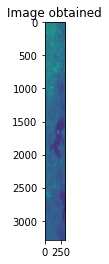



Matrix obtained:
 [[ 46 116 128 ...  70 104  76]
 [ 62 115 122 ...  60  75  54]
 [ 88 115 138 ...  76  63  51]
 ...
 [126 120 120 ... 104  93  91]
 [141 115 121 ...  99  99  96]
 [140 119 123 ...  97  95  89]]


In [ ]:
## Read the image obtained :
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# name of the file :
Rasterfile_name = file+'_RFL1580.tif'#"M3G20090718T054612_IBD2000.tif"
newRaster_filename = os.path.join(Rasterfolderpath,Rasterfile_name)
img=mpimg.imread(newRaster_filename)

plt.imshow(img[::-1])
plt.title('Image obtained')
plt.show()

## Read the matrix obtained :
result_band = result_array.GetRasterBand(1)
result_band = result_band.ReadAsArray()
print('\n\nMatrix obtained:\n',result_band)

# The End :)